### Capítulo 3 - Classificação 

Nesse capítulo vamos estudar a base MNIST para dígitos. A ideia é conseguir fazer um classificador capaz de diferenciar e classificar imagens de números de 0 a 9 escritos a mão.

In [8]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

/home/edu/.local/lib/python3.8/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [9]:
X, y = mnist['data'], mnist['target']

In [10]:
X.shape

(70000, 784)

In [11]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

70k exemplos com 784 pixels (as imagens são de 28x 28 pixels). Vejamos algumas delas.

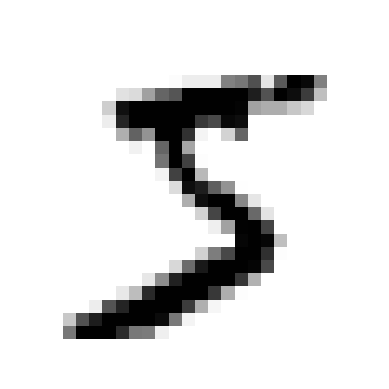

In [13]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap='binary')
plt.axis("off")
plt.show()

In [15]:
y[0]

'5'

In [18]:
y = y.astype(int)

Vamos separar o conjunto de treino e de teste:

In [19]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Treinando um classificador binário

Vamos começar simples e fazer um classificador que diz se um número é 5 ou não. Em um segundo momento faremos um que identifica qual é o número de 0 a 9 - no momento nosso classiifcador será binário: 5 ou não-5.

In [20]:
y_train_5 = (y_train == 5) # vai ser True quando for 5 e fasle quando não for: fizemos um binário
y_test_5 = (y_test == 5)

In [21]:
#Gradiente Descendente Estocástico que lida com bases grandes bem
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

Treinamos nosso classificador. Agora vamos ver se ele identifica que o número é 5:

In [24]:
sgd_clf.predict([some_digit])

array([ True])

Segundo o classificador é realmente o número 5

### Cálculo de desempenho
Usaremos a função cross_val_score para avaliar nosso modelo que detecta números 5. Aqui implementaremos o 3-fold-cross-validation, que usa sempre 1 pedaço da base de treino para o teste e 2 para treinar, de modo alternado. Isso nos dará 3 resultados de acurácia. O resultado reportado é a média delas.

In [25]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

Tudo mais que 95 - só que isso não é grande coisa dado que um modelo burro que chutasse tudo não-5 acertaria perto de 90% ( que é a proporção de não-5 na base)

In [26]:
import numpy as np
from sklearn.base import BaseEstimator
class Never5Classificier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)

In [27]:
never_5_clf = Never5Classificier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring = 'accuracy')

array([0.91125, 0.90855, 0.90915])

Acurácia não é uma medida muito legal para dados assimétricos. Mas não teríamos esse problema caso fosse acurácia balanceada:

In [28]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='balanced_accuracy')

array([0.73420707, 0.81596458, 0.90770452])

In [29]:
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring = 'balanced_accuracy')

array([0.5, 0.5, 0.5])

Agora nosso classificador não parece tão burro assim - mas também não é lá uma Brastemp.

### Matriz de confusão

A matriz de confusão é uma técnica para estudar os erros do modelo - nos permite ver quais confusões o modelo comete. Ela mostra uma contagem das previsões do modelo versus os rótulos verdadeiros.

Cada linha representa uma classe real e cada coluna representa uma classe prevista. As diagonais são os verdadeiros positivos ( deveria ser essa classe e realmente é essa classe) e os valores foras das diagonais são alguma confusão que está fazendo.

In [30]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [31]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

### Precision e Recall

Duas métricas para saber a qualidade do modelo são precision e recall. A precision avalia o acerto da **predição feita** enquanto o recall avalia a capacidade de detecção do modelo: olha para o rótulo e vê quantos deles o modelo encontrou.

In [32]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [33]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [34]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

### Tradeoff precision-recall

Aumentar um geralmente leva a reduzir o outro - isso porque um mede a detecção ( recall) e o outro o acerto da previsão ( precision). Para detectar tudo basta, em um extremo, dizer que todos os casos são de uma determinada classe - vai detectá-la, mas no mesmo ato também comete um monte de erros. Podemos modificar o limiar de decisão para privilegiar uma ou outra métrica - as vezes pode fazer sentido ter um limiar diferente de 0.5 ( que é o ponto de corte padrão).

In [35]:
y_scores = sgd_clf.decision_function([some_digit]) # ve qual o score atribuído
y_scores

array([2164.22030239])

In [36]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [37]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

Para obter os scores de todas as instâncias podemos pegar o decision function. Depois disso podemos pegar o precision recall curve e plotar com matplotlib

In [38]:
#vamos usar o cross_val_predict para obter todas as instâncias, depois ordenar isso e plotar pra ver o limiar

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [39]:
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [40]:
from sklearn.metrics import precision_recall_curve
# agora vamos usar o precision_recall_curve()
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

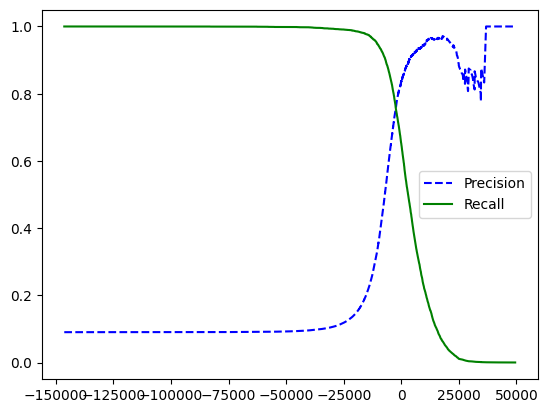

In [41]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1],'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label = 'Recall')
    plt.legend()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Ou podemos plotar diretamente precision vs recall. Vamnos destacar qual recall está em 90 de precision.

In [43]:
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

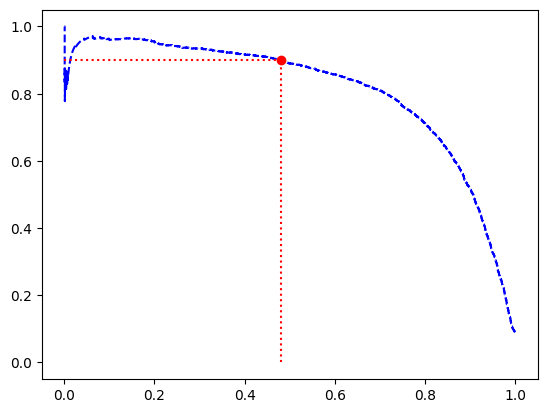

In [44]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls[:-1], precisions[:-1],'b--')
 
plot_precision_vs_recall(precisions, recalls)

#faz anotações no gráfico
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")

plt.show()

para fazer previsões com esse classificador setado com precision de 90%:

In [45]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [47]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [48]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

### Curva ROC
A Curva de Características de Operação (ROC) é uma forma popular de avaliar modelos. Ela avalia a taxa de verdadeiros positivos vs a taxa de falsos positivos. O FPR é a taxa de alarmes falsos do modelo. Vamos ver como ela se dá nesse exemplo:

In [49]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

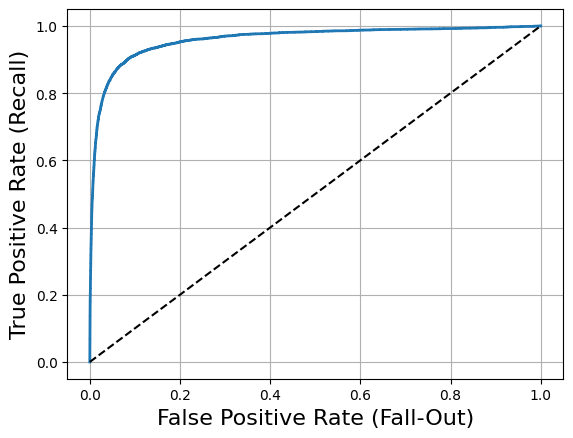

In [51]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plot_roc_curve(fpr,tpr)
plt.show()

Um bom classificador fica distante dessa linha pontilhada. O que é comum é usar a Área sobre a curva ROC (AUC, area under curve).

In [52]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Vamos agora treinar um classificador RandomForest e comparar com a ROC do nosso SGD Classifier. Precisamos de um decision function mas a classe RandomForest não o tem, mas tem predict proba.

In [53]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [54]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest , thresholds_forest = roc_curve(y_train_5, y_scores_forest)

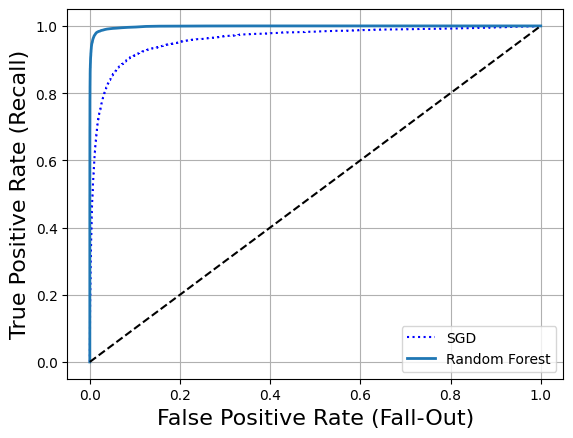

In [55]:
plt.plot(fpr, tpr, "b:", label = "SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

RandomForest deu uma surra.

In [56]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [68]:
forest_clf.fit(X_train,y_train_5)
y_forest = forest_clf.predict(X_test)

In [69]:
precision_score(y_test_5 , y_forest)

0.993581514762516

In [71]:
recall_score(y_test_5 , y_forest)

0.8677130044843049

### Classificação Multiclasse

O próximo passo é fazer um modelo que identifique números de 0 a 9, não apenas 5s.  Os classificadores internamente usam duas estratégias possíveis: One versus Rest e One Versus One ( que faz combinações exaustivas de modelos duelando dois a dois para decidir qual acerta).StopAsyncIteration
O scikitlearn cuida desses detalhes e torna o processo todo mais amigável.

In [72]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5])

Se usarmos o método decision_function veremos que lee retorna 10 scores por cada instância: isso é porque ele usou one versus rest em 10 classificadores diferentes usados internamente. É um score por classe.

In [74]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [75]:
np.argmax(some_digit_scores) # me dê o indice do score mais alto

5

In [76]:
svm_clf.classes_[5] # me diga qual a classe do score mais alto

5

In [77]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

aprox 86%. Vamos tentar melhorar isso escalando os valores dos pixels:

In [78]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [79]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring = 'accuracy')

array([0.8983, 0.891 , 0.9018])

Ficou melhor. Vamos agora analisar os erros para ver onde melhorar no modelo.

### Análise de erro

Usaremos a matriz de confusão para entender onde o modelo está errando.

In [80]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

In [ ]:
#vamos ver de modo grafico
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

Parece bom mas vamos aumentar o contraste disso focando na representação dos erros. Para tanto, vamos dividir o valor da matriz pelo número de imagens dessa classe: isso drá mais peso aos erros que forem proporcionalmente maiores.

In [ ]:
# agora vamos ponderar pelo tamanho da base para mostrar a taxa de erro, e não o erro absoluto
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

In [ ]:
#vamos preencher a diagnoal com zeros para dar mais contraste apenas aos erros
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Dado que as linhas representam as classes reais e as colunas as classes previstas então fica claro que muitas imagens de 3 estão classificadas erroneamente como 8. Além disso, 3 e 5 são confundidos em ambas as direções. Vejamos.

In [ ]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

### Classificação multi rótulo

E se quisermos prever mais de um rótulo ao mesmo tempo? Isso é possível. Vejamos por exemplo um classificador que além de dizer o número, diz se ele é impar ou par ou se é grande ( 7 a 9)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >=7) #rótulo 1: é um número grande? 7 a 9
y_train_odd = (y_train %2 ==1) # é impar?
y_multilabel = np.c_[y_train_large, y_train_odd] #aqui está a mágica

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

In [ ]:
knn_clf.predict([some_digit])